## Import Modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential, Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import json
from datetime import datetime
from keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import Callback
import time
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

2025-04-13 01:36:03.841677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744508163.870599    2286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744508163.884225    2286 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Enable GPU

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         tf.config.set_visible_devices(gpus[0], 'GPU')
#         print("Using GPU:", gpus[0])
#     except RuntimeError as e:
#         print(e)

## Load the Dataset

In [3]:
# Define image paths
clean_path = "../my_dataset/celeba_64x64_25000/clean"
noisy_path = "../my_dataset/celeba_64x64_25000/noisy"

# Load all image filenames
image_filenames = sorted(os.listdir(clean_path))

# Load images
clean_images = []
noisy_images = []

for fname in image_filenames:
    clean_img = Image.open(os.path.join(clean_path, fname)).convert('RGB')
    noisy_img = Image.open(os.path.join(noisy_path, fname)).convert('RGB')
    
    clean_images.append(np.array(clean_img))
    noisy_images.append(np.array(noisy_img))

# Convert lists to numpy arrays
clean_images = np.array(clean_images)
noisy_images = np.array(noisy_images)

# Split into training and testing sets
x_train_clean, x_test_clean, x_train_noisy, x_test_noisy = train_test_split(
    clean_images, noisy_images, test_size=0.1, random_state=42)

# Normalize pixel values to [0, 1]
x_train_clean = x_train_clean.astype('float32') / 255.
x_test_clean = x_test_clean.astype('float32') / 255.
x_train_noisy = x_train_noisy.astype('float32') / 255.
x_test_noisy = x_test_noisy.astype('float32') / 255.

# Shuffle data while maintaining alignment
perm = np.random.permutation(len(x_train_clean))
x_train_clean = x_train_clean[perm]
x_train_noisy = x_train_noisy[perm]

perm_test = np.random.permutation(len(x_test_clean))
x_test_clean = x_test_clean[perm_test]
x_test_noisy = x_test_noisy[perm_test]


## Exploratory Data Analysis

### Dataset Size

In [4]:
print(f"Number of training images: {x_train_clean.shape[0]}")
print(f"Number of test images: {x_test_clean.shape[0]}")

Number of training images: 22500
Number of test images: 2500


### Distribution and Value Ranges

In [5]:
print("Image shape (train):", x_train_clean[0].shape)
print("Pixel value range (clean):", x_train_clean.min(), "to", x_train_clean.max())
print("Pixel value range (noisy):", x_train_noisy.min(), "to", x_train_noisy.max())

Image shape (train): (64, 64, 3)
Pixel value range (clean): 0.0 to 1.0
Pixel value range (noisy): 0.0 to 1.0


### Pixel Intensity Distributions

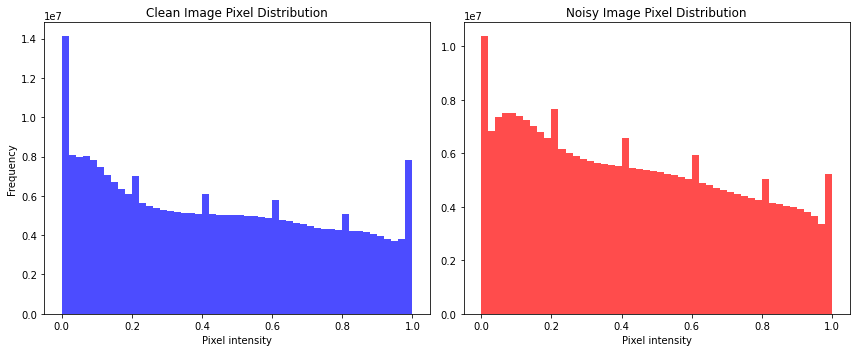

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x_train_clean.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Clean Image Pixel Distribution")
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(x_train_noisy.flatten(), bins=50, color='red', alpha=0.7)
plt.title("Noisy Image Pixel Distribution")
plt.xlabel("Pixel intensity")

plt.tight_layout()
plt.show()

### Visualize Images

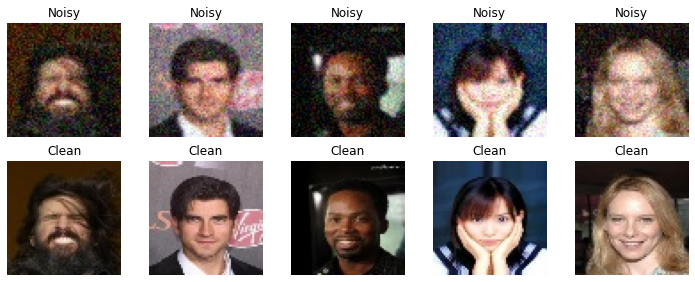

In [7]:
def show_samples(clean, noisy, num_samples=5):
    plt.figure(figsize=(num_samples * 2, 4))
    for i in range(num_samples):
        # Noisy
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')
        
        # Clean
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(x_train_clean, x_train_noisy)

In [8]:
epochs = 2000
batch_size = 16
alpha = 0
loss_function = "vgg_mse"
model_name = f"UDnCNN_{loss_function}_a{alpha}_e{epochs}_b{batch_size}_v2"
print(model_name)

UDnCNN_vgg_mse_a0_e2000_b16_v2


## Model Creation

### VGG Loss function

In [9]:
# Load VGG model without top layers
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
vgg.trainable = False

# Create model up to block3_conv3
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)

def perceptual_loss_vgg(y_true, y_pred):
    # Scale to [0, 255] for VGG
    y_true_vgg = preprocess_input(y_true * 255.0)
    y_pred_vgg = preprocess_input(y_pred * 255.0)

    # Extract features
    features_true = vgg_model(y_true_vgg)
    features_pred = vgg_model(y_pred_vgg)

    # L2 loss between features
    return tf.reduce_mean(tf.square(features_true - features_pred))

def combined_loss_mse_perceptual(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    perceptual = perceptual_loss_vgg(y_true, y_pred)
    return alpha * mse + (1 - alpha) * perceptual  # tune weights if needed

I0000 00:00:1744508380.063895    2286 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 94412 MB memory:  -> device: 0, name: NVIDIA GH200 480GB, pci bus id: 0000:dd:00.0, compute capability: 9.0


In [10]:
input_img = Input(shape=(x_train_clean.shape[1], x_train_clean.shape[2], x_train_clean.shape[3]))

# Initial Conv + ReLU
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ReLU()(x)

# Downsampling block 1
x1 = Conv2D(64, (3, 3), padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = ReLU()(x1)
p1 = MaxPooling2D(pool_size=(2, 2))(x1)

# Downsampling block 2
x2 = Conv2D(64, (3, 3), padding='same')(p1)
x2 = BatchNormalization()(x2)
x2 = ReLU()(x2)
p2 = MaxPooling2D(pool_size=(2, 2))(x2)

# Middle block 1
x3 = Conv2D(64, (3, 3), padding='same')(p2)
x3 = BatchNormalization()(x3)
x3 = ReLU()(x3)

# Middle block 2
x4 = Conv2D(64, (3, 3), padding='same')(x3)
x4 = BatchNormalization()(x4)
x4 = ReLU()(x4)

# Upsampling block 1 + skip connection with x2
u1 = UpSampling2D(size=(2, 2))(x4)
u1 = Add()([u1, x2])
u1 = Conv2D(64, (3, 3), padding='same')(u1)
u1 = BatchNormalization()(u1)
u1 = ReLU()(u1)

# Upsampling block 2 + skip connection with x1
u2 = UpSampling2D(size=(2, 2))(u1)
u2 = Add()([u2, x1])
u2 = Conv2D(64, (3, 3), padding='same')(u2)
u2 = BatchNormalization()(u2)
u2 = ReLU()(u2)

# Final output layer
output = Conv2D(3, (3, 3), padding='same')(u2)

# Skip Connection (Residual Learning)
output_img = Add()([input_img, output])

model = Model(inputs=input_img, outputs=output_img)

model.compile(optimizer='adam', loss=combined_loss_mse_perceptual)
# model.summary()

## Train the model

### Callback to Track Time

In [11]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()  # returns float in seconds

    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.start_time

time_callback = TimeHistory()

### Train

In [ ]:
history = model.fit(
    x_train_noisy, x_train_clean,
    validation_data=(x_test_noisy, x_test_clean),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[time_callback]
)
print("Training time (seconds):", round(time_callback.total_time, 2))

Epoch 1/2000


I0000 00:00:1744508394.067825    3089 service.cc:148] XLA service 0xe8c6c40019c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744508394.067855    3089 service.cc:156]   StreamExecutor device (0): NVIDIA GH200 480GB, Compute Capability 9.0
2025-04-13 01:39:54.153831: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744508394.557591    3089 cuda_dnn.cc:529] Loaded cuDNN version 90701


  56/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2433691.0000     

I0000 00:00:1744508397.300219    3089 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 262001.7969 - val_loss: 54081.8438
Epoch 2/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 51885.1836 - val_loss: 49724.1133
Epoch 3/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 48221.4102 - val_loss: 48238.3164
Epoch 4/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 45377.9883 - val_loss: 46823.9961
Epoch 5/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 42112.4219 - val_loss: 40288.5977
Epoch 6/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 39196.9531 - val_loss: 53833.9844
Epoch 7/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 38211.3828 - val_loss: 37156.7773
Epoch 8/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 35978.0898 - val_loss: 37573.4102
Epoch 9/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 34970.2148 - val_loss: 35365.4961
Epoch 10/2000
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 34244.4727 - val_loss: 37623.9727
Epoch 11/2000
1407/1407 ━━━━━━

### Save

In [ ]:
model_dir = f"./models/{model_name}"
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, "model.keras"))
print(f"\n✅ Model saved to: {model_dir}")

## Evaluate the Model

### Predict

In [ ]:
predictions = model.predict(x_test_noisy)

### Evaluate

In [ ]:
mae = np.mean(np.abs(predictions - x_test_clean))
mse = np.mean((predictions - x_test_clean) ** 2)

psnr_total, ssim_total = 0, 0
for i in range(len(x_test_clean)):
    psnr_total += peak_signal_noise_ratio(x_test_clean[i], predictions[i], data_range=1.0)
    ssim_total += structural_similarity(x_test_clean[i], predictions[i], channel_axis=-1, data_range=1.0)

psnr_avg = psnr_total / len(x_test_clean)
ssim_avg = ssim_total / len(x_test_clean)

### Save Metadata

In [ ]:
metadata = {
    "model_name": model_name,
    "created_at": datetime.now().isoformat(),
    "loss_function": loss_function,
    "alpha": alpha,
    "epochs": int(epochs),
    "batch_size": int(batch_size),
    "training_time_seconds": round(float(time_callback.total_time), 2),
    "dataset_info": {
        "train_size": int(x_train_clean.shape[0]),
        "test_size": int(x_test_clean.shape[0]),
        "image_shape": list(map(int, x_train_clean.shape[1:]))
    },
    "evaluation_metrics": {
        "mae": round(float(mae), 6),
        "mse": round(float(mse), 6),
        "psnr_avg": round(float(psnr_avg), 3),
        "ssim_avg": round(float(ssim_avg), 3)
    }
}
with open(os.path.join(model_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print(f"\n✅ Metadata saved to: {model_dir}")

### Visualize the Results

In [ ]:
def show_predictions(noisy, clean, predicted, num_images=5):
    plt.figure(figsize=(num_images * 3, 9))
    for i in range(num_images):
        # Noisy
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Predicted
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Clean
        plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(x_test_noisy, x_test_clean, predictions)

In [ ]:
def visualize_and_save_denoising(noisy, predicted, clean, model_dir, num_images=5):
    """
    Visualize and save a comparison of noisy, denoised, and clean images.
    
    Args:
        noisy (numpy array): Noisy input images
        predicted (numpy array): Model predictions (denoised images)
        clean (numpy array): Ground truth clean images
        model_dir (str): Directory where the visualization image will be saved
        num_images (int): Number of image samples to visualize
    """
    plt.figure(figsize=(num_images * 3, 9))

    for i in range(num_images):
        # Noisy input
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Denoised (model output)
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted[i])
        plt.title("Denoised")
        plt.axis('off')

        # Ground truth
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis('off')

    plt.tight_layout()
    
    # Save figure
    save_path = os.path.join(model_dir, "denoising_visualization.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()  # Close the figure to free memory

    print(f"📸 Visualization saved to: {save_path}")

visualize_and_save_denoising(
    noisy=x_test_noisy,
    predicted=predictions,
    clean=x_test_clean,
    model_dir=model_dir,
    num_images=5  # You can increase this number if desired
)